In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV 

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('./dataset/Loan information.csv')
target = 'Disbursed'
IDcol = 'ID'

### 参数调优的一般办法
1. 选择较高的学习速率(learning rate)。一般情况下，学习速率的值为0.1。但是，对于不同的问题，理想的学习速率有时候会在0.05到0.3之间波动。选择对应于此学习速率的理想决策树数量。XGBoost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量。 

2. 对于给定的学习速率和决策树数量，进行决策树特定参数调优(max_depth, min_child_weight, gamma, subsample, colsample_bytree)。

3. xgboost的正则化参数的调优。(lambda, alpha)。这些参数可以降低模型的复杂度，从而提高模型的表现。

4. 降低学习速率，确定理想参数。

In [13]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])#设置实际的训练轮数
        print ("cv 最佳迭代：%d , auc-mean: %f" % (cvresult.shape[0],cvresult.iloc[cvresult.shape[0]-1,0])) 
    
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')#训练模型
        
    #预测
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

                    
    xgb.plot_importance(alg)

cv 最佳迭代：128 , auc-mean: 0.844927

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896723


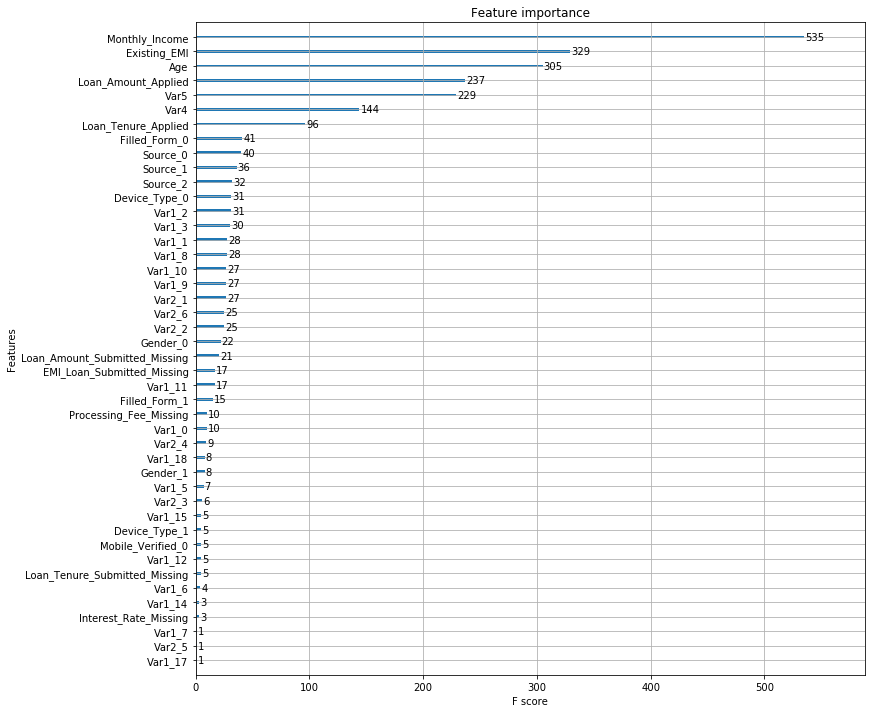

In [14]:
#第一步：确定学习速率和tree_based 参数调优估计器数目。

#为了确定boosting 参数，我们要先给其它参数一个初始值。咱们先按如下方法取值： 
#1、max_depth = 5 :这个参数的取值最好在3-10之间。我选的起始值为5，但是你也可以选择其它的值。起始值在4-6之间都是不错的选择。 
#2、min_child_weight = 1:在这里选了一个比较小的值，因为这是一个极不平衡的分类问题。因此，某些叶子节点下的值会比较小。 
#3、gamma = 0: 起始值也可以选其它比较小的值，在0.1到0.2之间就可以。这个参数后继也是要调整的。 
#4、subsample,colsample_bytree = 0.8: 这个是最常见的初始值了。典型值的范围在0.5-0.9之间。 
#5、scale_pos_weight = 1: 这个值是因为类别十分不平衡。 
#注意哦，上面这些参数的值只是一个初始的估计值，后继需要调优。这里把学习速率就设成默认的0.1。然后用xgboost中的cv函数来确定最佳的决策树数量。前文中的函数可以完成这个工作。

predictors = [x for x in train.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=27)
modelfit(xgb1, train, predictors)

In [15]:
#对于给定的学习速率和决策树数量，进行决策树特定参数调优,关系比较大的放一起调
#调 max_depth 和 min_child_weight
param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=128, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])# gsearch1 = GridSearchCV()只是创建一个实例，gsearch1.fit才是真正的用参数拟合模型
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83665, std: 0.00842, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.83766, std: 0.00886, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.83690, std: 0.00834, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.84043, std: 0.00778, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: 0.84116, std: 0.00598, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: 0.84117, std: 0.00590, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.83886, std: 0.00550, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: 0.83756, std: 0.00594, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: 0.83797, std: 0.00343, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: 0.82910, std: 0.00595, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.83129, std: 0.00527, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: 0.83365, std: 0.00635, params: {'min_child_weight': 5, 'max_depth': 9}],
 {'max_depth': 5, 'min_child_weight': 5

In [18]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84031, std: 0.00658, params: {'min_child_weight': 4, 'max_depth': 4},
  mean: 0.84061, std: 0.00700, params: {'min_child_weight': 5, 'max_depth': 4},
  mean: 0.84125, std: 0.00723, params: {'min_child_weight': 6, 'max_depth': 4},
  mean: 0.83988, std: 0.00612, params: {'min_child_weight': 4, 'max_depth': 5},
  mean: 0.84123, std: 0.00619, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.83995, std: 0.00591, params: {'min_child_weight': 6, 'max_depth': 5},
  mean: 0.83905, std: 0.00635, params: {'min_child_weight': 4, 'max_depth': 6},
  mean: 0.83904, std: 0.00656, params: {'min_child_weight': 5, 'max_depth': 6},
  mean: 0.83844, std: 0.00682, params: {'min_child_weight': 6, 'max_depth': 6}],
 {'max_depth': 4, 'min_child_weight': 6},
 0.8412491517082822)

In [19]:
#调gamma
param_test3 = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84125, std: 0.00723, params: {'gamma': 0},
  mean: 0.83996, std: 0.00695, params: {'gamma': 0.1},
  mean: 0.84045, std: 0.00639, params: {'gamma': 0.2},
  mean: 0.84032, std: 0.00673, params: {'gamma': 0.3},
  mean: 0.84061, std: 0.00692, params: {'gamma': 0.4},
  mean: 0.84085, std: 0.00722, params: {'gamma': 0.5}],
 {'gamma': 0},
 0.8412491517082822)

In [20]:
#调subsample 和 colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83723, std: 0.00889, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83834, std: 0.00772, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.83946, std: 0.00813, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.83845, std: 0.00831, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.83816, std: 0.00651, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.83797, std: 0.00668, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.83956, std: 0.00824, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.83892, std: 0.00626, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.83914, std: 0.00794, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.83974, std: 0.00687, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.84102, std: 0.00715, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.84029, std: 0.00645, params: {'subsample': 0.9, 'colsample_bytree'

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

In [ ]:
#调正则化项
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

cv 最佳迭代：1723 , auc-mean: 0.845514

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.885043


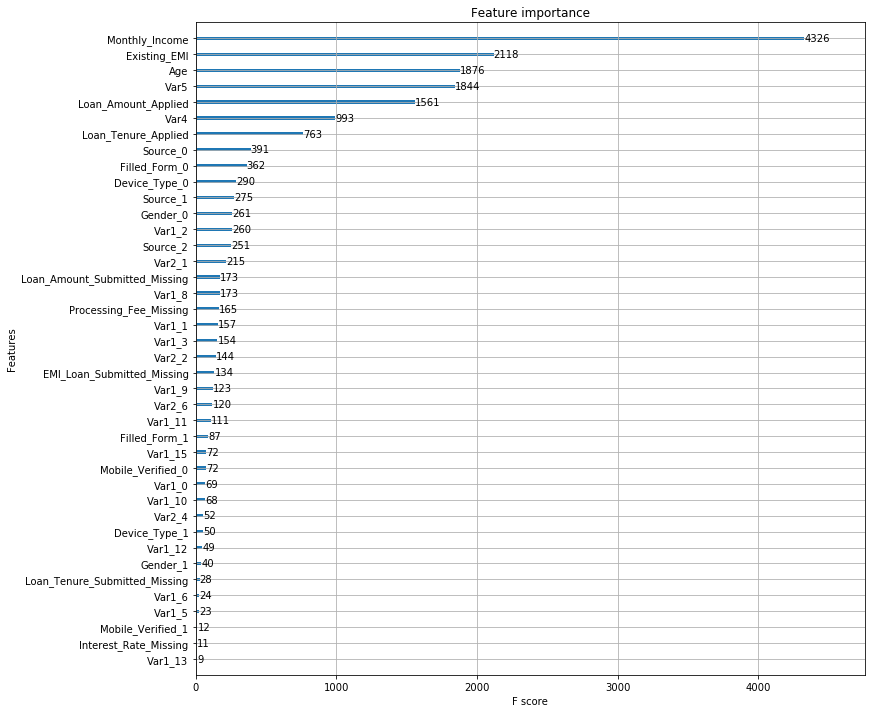

In [21]:
#最后， 减少学习率增加迭代次数
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)